## The MultiONet method for Parametric PDEs
- Implementation is also available in Kaggle notebook: [https://www.kaggle.com/code/yhzang32/multionet4darcyflow](https://www.kaggle.com/code/yhzang32/multionet4darcyflow)
- Datasets in the lesson are available through: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

## (1) Problem description
The Darcy's problem is considered as follows:
\begin{equation}
\begin{split}
-\nabla\cdot(a\nabla u) &= f \\
u &= 0
\end{split}
\end{equation}
The goal of the parametric PDE problem is to learn a mapping from the PDE coefficient $a$ to the solution $u$, i.e.,:
$$
\mathcal{G}: a(x)\in\mathcal{A}\rightarrow u(x)\in\mathcal{U}
$$

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of a_train: torch.Size([1000, 841])
The shape of u_train: torch.Size([1000, 841])
The shape of x_train: torch.Size([841, 2])


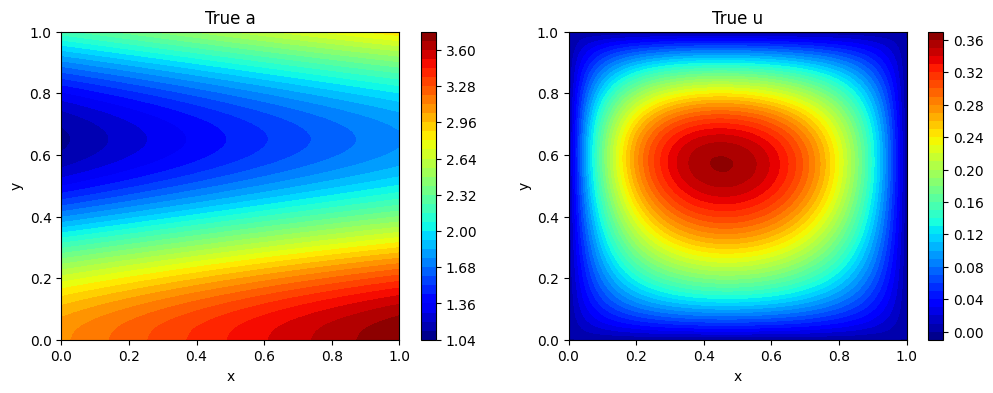

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(3407)
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('DarcyFlow_train.mat', 'r')
data_test = h5py.File('DarcyFlow_test.mat', 'r')
print(data_train.keys()) 
#
def get_data(data, ndata=1000):
    # The labeled training data (a,u)
    a = np.array(data["coeff"][...,:ndata]).T
    u = np.array(data["sol"][:,:ndata]).T
    # The coordinates
    x1, x2 = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np.vstack([x1.ravel(), x2.ravel()]).T
    gridx = mesh.reshape(-1, 2)
    #
    a = torch.tensor(a, dtype=dtype).reshape(ndata, -1)
    u = torch.tensor(u, dtype=dtype).reshape(ndata, -1)
    x = torch.tensor(gridx, dtype=dtype)
    return a, u, x, gridx
a_train, u_train, x_train, gridx = get_data(data_train, ndata=1000)
a_test, u_test, x_test, gridx = get_data(data_test, ndata=200)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of x_train:', x_train.shape)

####### Visualize the training data 
a_show, u_show = a_train[0], u_train[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(a_show), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True a')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_show), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

## (2) The MultiONet architecture

In [2]:
import torch.nn as nn
#
class MultiONet(nn.Module):
    
    def __init__(self, in_size_x, in_size_a, hidden_list, dtype):
        super(MultiONet, self).__init__()
        # The activations
        self.activation_trunk = nn.ReLU()
        self.activation_branch = nn.ReLU()
            
        # The input layer: 
        self.fc_x_in = nn.Linear(in_size_x, hidden_list[0], dtype=dtype)
        self.fc_a_in = nn.Linear(in_size_a, hidden_list[0], dtype=dtype)
        
        # The hidden layer
        net_x, net_a = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            net_x.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            net_a.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in =  hidden 
        self.net_x = nn.Sequential(*net_x)
        self.net_a = nn.Sequential(*net_a)
        
        # Weights and bias
        self.w = torch.nn.ParameterList(
            [torch.nn.Parameter(torch.tensor(0.0)) for _ in range(len(hidden_list))]
            )
        self.b = torch.nn.ParameterList(
            [torch.nn.Parameter(torch.tensor(0.0)) for _ in range(len(hidden_list))]
            )
        
    def forward(self, x, a):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        #### THe input layer
        # size(mesh_size, hidden_size)
        x = self.activation_trunk(self.fc_x_in(x))
        # size(n_batch, hidden_size)
        a = self.fc_a_in(a)
        
        #### The conv layer
        out = 0. 
        for net_t, net_b, w, b in zip(self.net_x, self.net_a, self.w, self.b):
            # size(mesh_size, x_size) -> size(mesh_size, p)
            x = self.activation_trunk(net_t(x))
            # size(batch_size, a_size) -> size(batch_size, p)
            a = net_b(self.activation_branch(a))
            #
            out += torch.einsum('bh,mh->bm', a, x) * w + b
            
        ##### The output layer
        out = out/len(self.net_x)

        return out
#
hidden_list = [128, 128, 128]
#
model_u = MultiONet(2, 841, hidden_list, dtype).to(device)
#
from torchsummary import summary
summary(model_u, [(2,), (841,)], device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]         107,776
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
            Linear-8                  [-1, 128]          16,512
              ReLU-9                  [-1, 128]               0
             ReLU-10                  [-1, 128]               0
           Linear-11                  [-1, 128]          16,512
           Linear-12                  [-1, 128]          16,512
             ReLU-13                  [-1, 128]               0
             ReLU-14                  [

### (3) The loss function
$$
L(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \sqrt{\sum_{j=1}^{N_p} \left| \mathcal{G}_\theta(a^{(i)}(\Xi))(x_j) - u^{(i)}(x_j) \right|^2}
$$

In [3]:
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
    
    def loss_data(self, a_batch, u_batch):
        '''loss term'''
        x, a, u = x_train.to(self.device), a_batch.to(self.device), u_batch.to(self.device)
        #
        u_pred = self.u_model(x, a) * torch.sin(np.pi * x[...,0]) * torch.sin(np.pi * x[...,1])
        loss = torch.norm(u-u_pred, 2, 1)
        loss = torch.mean(loss)
        
        return loss 

    def get_error(self, a, u):
        '''L2 relative error'''
        x, a, u = x_train.to(self.device), a.to(self.device), u.to(self.device)
        # 
        u_pred = self.u_model(x, a) * torch.sin(np.pi * x[...,0]) * torch.sin(np.pi * x[...,1])
        error = torch.norm(u-u_pred, 2, 1) / torch.norm(u, 2, 1)

        return torch.mean(error)

### (4) Training the model

In [4]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, a:torch.tensor, u:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            u: size(batch_size, u_size)
        '''
        self.a = a 
        self.u = u
    
    def __getitem__(self, index):
        return self.a[index], self.u[index]

    def __len__(self):
        return self.a.shape[0]
        
train_loader = DataLoader(MyDataset(a_train, u_train), batch_size=50, shuffle=True)


################# Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
loss_list, error_list = [], []
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for a_batch, u_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_data(a_batch, u_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    with torch.no_grad():
        error = lossClass.get_error(a_test, u_test)
        error_list.append(error.item())
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
        print('error_test:', error_list.pop())
print('The consuming time is:', time.time()-t0)

  5%|██                                      | 101/2000 [00:08<03:38,  8.69it/s]

Epoch:99, The loss is:0.15621423721313477
error_test: 0.0383375845849514


 10%|████                                    | 201/2000 [00:18<02:44, 10.92it/s]

Epoch:199, The loss is:0.0914454460144043
error_test: 0.014704241417348385


 15%|██████                                  | 301/2000 [00:28<02:35, 10.92it/s]

Epoch:299, The loss is:0.07204009592533112
error_test: 0.02334318682551384


 20%|████████                                | 403/2000 [00:36<01:53, 14.09it/s]

Epoch:399, The loss is:0.05363870784640312
error_test: 0.01755194365978241


 25%|██████████                              | 501/2000 [00:43<01:52, 13.28it/s]

Epoch:499, The loss is:0.03820592910051346
error_test: 0.007409430108964443


 30%|████████████                            | 603/2000 [00:50<01:31, 15.23it/s]

Epoch:599, The loss is:0.033140815794467926
error_test: 0.007203393150120974


 35%|██████████████                          | 703/2000 [00:57<01:23, 15.55it/s]

Epoch:699, The loss is:0.03496686369180679
error_test: 0.007999004796147346


 40%|████████████████                        | 803/2000 [01:03<01:16, 15.63it/s]

Epoch:799, The loss is:0.03262164816260338
error_test: 0.006393548101186752


 45%|██████████████████                      | 903/2000 [01:10<01:09, 15.74it/s]

Epoch:899, The loss is:0.022292722016572952
error_test: 0.0048833126202225685


 50%|███████████████████▌                   | 1003/2000 [01:16<01:03, 15.61it/s]

Epoch:999, The loss is:0.02383420802652836
error_test: 0.004992804490029812


 55%|█████████████████████▍                 | 1101/2000 [01:23<01:08, 13.18it/s]

Epoch:1099, The loss is:0.019922906532883644
error_test: 0.004133747890591621


 60%|███████████████████████▍               | 1203/2000 [01:30<00:51, 15.58it/s]

Epoch:1199, The loss is:0.01994168758392334
error_test: 0.005063910037279129


 65%|█████████████████████████▍             | 1303/2000 [01:37<00:44, 15.60it/s]

Epoch:1299, The loss is:0.01703411340713501
error_test: 0.003652043640613556


 70%|███████████████████████████▎           | 1403/2000 [01:43<00:39, 15.12it/s]

Epoch:1399, The loss is:0.017916936427354813
error_test: 0.0035509299486875534


 75%|█████████████████████████████▎         | 1503/2000 [01:50<00:33, 14.96it/s]

Epoch:1499, The loss is:0.017512571066617966
error_test: 0.004323924425989389


 80%|███████████████████████████████▏       | 1601/2000 [01:56<00:32, 12.44it/s]

Epoch:1599, The loss is:0.015455543994903564
error_test: 0.0032650146167725325


 85%|█████████████████████████████████▏     | 1703/2000 [02:05<00:19, 15.30it/s]

Epoch:1699, The loss is:0.0147737767547369
error_test: 0.0031435934361070395


 90%|███████████████████████████████████▏   | 1803/2000 [02:11<00:12, 15.63it/s]

Epoch:1799, The loss is:0.01442987471818924
error_test: 0.003166540525853634


 95%|█████████████████████████████████████  | 1903/2000 [02:18<00:06, 15.86it/s]

Epoch:1899, The loss is:0.014180135913193226
error_test: 0.0030775300692766905


100%|███████████████████████████████████████| 2000/2000 [02:24<00:00, 13.84it/s]

Epoch:1999, The loss is:0.0140627296641469
error_test: 0.00302074640057981
The consuming time is: 144.53448295593262


### (5) Performance on testing dataset
The relative error:
$$
L^2 = \sqrt{\sum_i\frac{\|u(x_i)-u_{nn}(x_i)\|^2}{\|u(x_i)\|^2}}
$$
where $u$ represents the true solution and $u_{nn}$ is the network approximation.

The shape of u_pred: torch.Size([200, 841])
The average l2 error: tensor(0.0030)


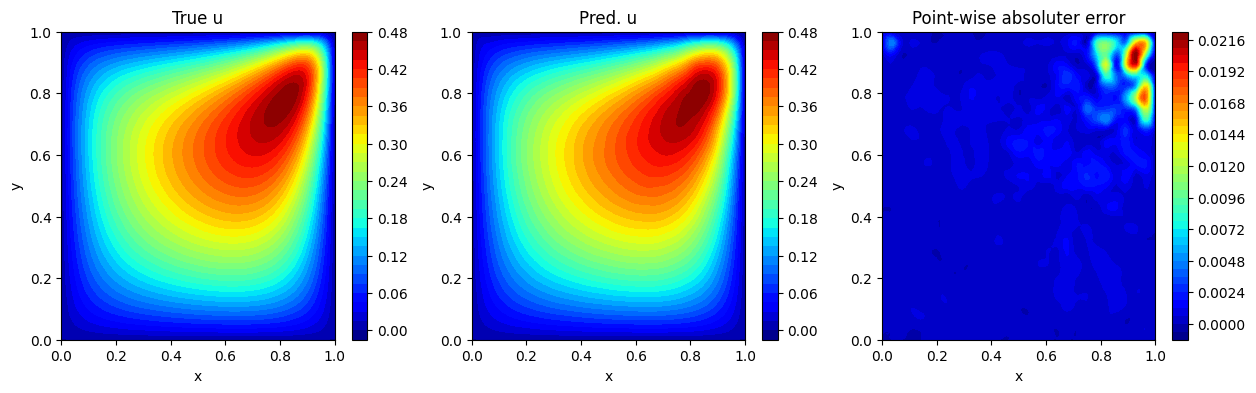

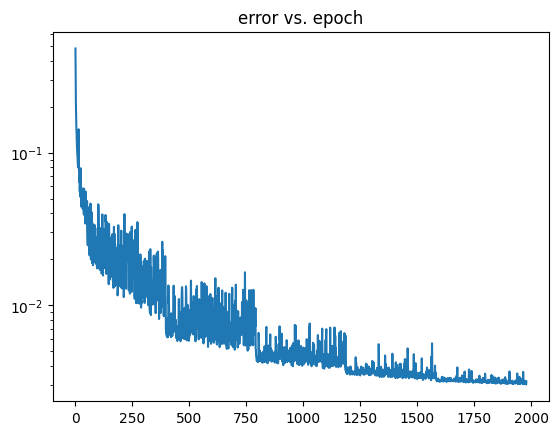

In [5]:
#######################################
# The L2 relative error
#######################################
def L2_error(u, u_pred):
    ''' '''
    l2 = torch.norm(u-u_pred, 2, 1) / torch.norm(u, 2, 1)
    return l2
# Make prediction with trained model
u_test_pred = model_u(x_test.to(device), a_test.to(device)).detach().cpu()
u_test_pred = u_test_pred * torch.sin(np.pi * x_test[...,0]) * torch.sin(np.pi * x_test[...,1])
# x_batch = x_test.repeat((200, 1, 1))
# u_test_pred = u_test_pred * torch.sin(np.pi * x_batch[...,0]) * torch.sin(np.pi * x_batch[...,1])
print('The shape of u_pred:', u_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(u_test, u_test_pred)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
u_true, u_pred = u_test[0], u_test_pred[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_true), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True u')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_pred), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Pred. u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(np.abs(u_true-u_pred)), (x_plot, y_plot), method='cubic')
cntr2 = axs.flat[:][2].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()
#############################
plt.figure()
plt.semilogy(error_list)
plt.title('error vs. epoch')
plt.show()